# Visual Similarity - Preprocess Data
## The purpose of this notebook is to preprocess image data.
## The data we are using consists of fashion images of women wearing dresses. It has annotaion around the dress whichw e need ot remove for further classification task.

# Import Libraries

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta, iqr

In [2]:
import warnings
warnings.filterwarnings( "ignore")

In [3]:
# intsall opencv
!pip install opencv-python
# !pip install boto3

In [4]:
# intsall rqdm
!pip install tqdm

In [5]:
import cv2 # we use cv2 to read image data and also preprocess the image data
# import boto3
import urllib # we use urllib to read image from image_url

In [6]:
from tqdm import tqdm #tqdm to track progress

## Read input data

The following data has product images of dresses. It has annotation around the dresses which we need to remove for our analysis.

In [7]:
input_data = pd.read_csv('dress.csv')

In [8]:
# display top5 rows
input_data.head()

,_unit_id,category,category:confidence,image_url
0,851505458,ikat,0.3487,http://s3-eu-west-1.amazonaws.com/we-attribute...
1,851505459,plain,1.0000,http://s3-eu-west-1.amazonaws.com/we-attribute...
2,851505460,polka dot,0.6709,http://s3-eu-west-1.amazonaws.com/we-attribute...
3,851505461,plain,1.0000,http://s3-eu-west-1.amazonaws.com/we-attribute...
4,851505462,geometry,0.7035,http://s3-eu-west-1.amazonaws.com/we-attribute...


## Remove annotations

In [14]:
# get image_urls
images = input_data.image_url.tolist()
images[0]

'http://s3-eu-west-1.amazonaws.com/we-attributes/dress/23/5f635c0fa59f4270a6953f67dcddcda3.jpg.png'

In [9]:
def show_image_from_url(image_url):

  """
  Fetches image online from the image_url and plots it as it is using matplotlib's pyplot's image show
  """

  response = urllib.request.urlopen(image_url)
  image = np.asarray(bytearray(response.read()), dtype="uint8")
  image_bgr = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
  plt.imshow(image_rgb), plt.axis('off')

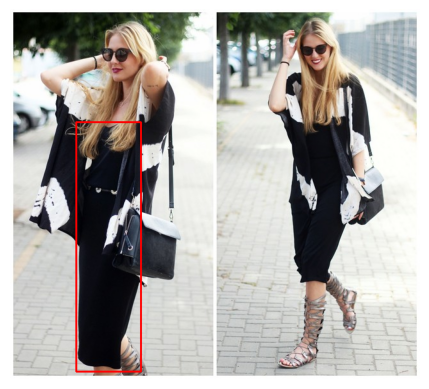

In [10]:
# plot an example image
plt.figure()
show_image_from_url(input_data['image_url'].loc[9564])

As we can see there's annotation around the dress noted by the red box. We need to clean this before suing the data for futher processing.

## Remove mask from the images

In [11]:
def get_image_rgb(image_url):
    """
    Reads an image from image_url and returns it in the RGB format
    """
    
    response = urllib.request.urlopen(image_url)
    image = np.asarray(bytearray(response.read()), dtype="uint8")
    image_bgr = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    return image_rgb

In [12]:
def remove_image_annotation(image_rgb):
    """
    Removes the red annotation box from the image
    """
    # Convert the image from RGB color map to HSV color map
    ## This will convert the red annotation to cyan
    img_hsv=cv2.cvtColor(image_rgb, cv2.COLOR_BGR2HSV)
    # Define HSV color map of cyan
    lo = np.uint8([120, 254,100]) 
    hi = np.uint8([120,255,255])
    
    mask = cv2.inRange(img_hsv,lo,hi) # Initialize mask
    
    # Inpaint red box
    image_rgb_clean = cv2.inpaint(image_rgb,mask,3,cv2.INPAINT_TELEA)
    return image_rgb_clean

In [15]:
rgb_images = []
clean_images = []
offset = 10529
for i in tqdm(range(len(images[0:10]))):
    try:
        image_rgb = get_image_rgb(images[i+offset])
        rgb_images.append(image_rgb)
        clean_image = remove_image_annotation(image_rgb)
        clean_images.append(clean_image)
        r = cv2.imwrite('im_{}.png'.format(i+offset), clean_image) #save the clean image locally
    except:
        image_rgb = None
        clean_image = None
        rgb_images.append(image_rgb)
        clean_images.append(clean_image)

100%|███████████████████████████████████████████| 10/10 [00:14<00:00,  1.47s/it]


## Visualize preprocessed images

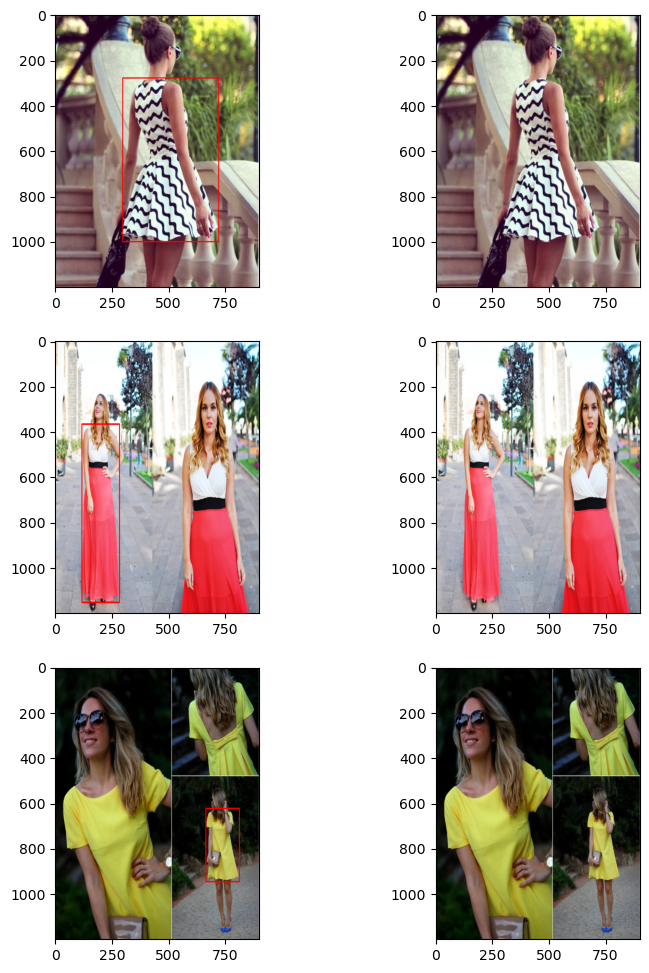

In [33]:
f, axarr = plt.subplots(3,2, figsize=(9, 12))
for i in range(3):  
    axarr[i,0].imshow(cv2.resize(rgb_images[i], (900, 1200)))
    axarr[i,1].imshow(cv2.resize(clean_images[i], (900, 1200)))

We can see that the red box used to annotate an image on the left has been removed from the right image

# Conclusion

We can use this script to visualize and clean the image that can be further used for subsequent tasks such as clustering or image classification.